# Problem 1

**Binary Sequences with No Adjacent 1s:** compute the expected number of $1s$: in a good sequence if all good sequences are equal likely ($\mathrm{m}=150$)

(a) Find the analytical solution

In [37]:
def get_no_adjacent(m):
    f = [0] * (m + 1)
    g = [0] * (m + 1)
    f[0], f[1] = 1, 2
    g[0], g[1] = 0, 1

    for i in range(2, m + 1):
        f[i] = f[i - 2] + f[i - 1]
        g[i] = g[i - 2] + g[i - 1] + f[i - 2]
    return g[m] / f[m]


m = 150
print(f'The analytical solution of {m = } is {get_no_adjacent(m)}')

The analytical solution of m = 150 is 41.6117667420032


(b) Implement a DTMC based MCMC algorithm for approximate computing

(c) Implement a CTMC based MCMC algorithm for approximate computing

In [30]:
import numpy as np
import tqdm

def is_good(s, flip_bit, m):
    if flip_bit == 0:
        if s[0] == '1' and s[1] == '1':
            return False
    elif flip_bit == m - 1:
        if s[m - 2] == '1' and s[m - 1] == '1':
            return False
    else:
        if s[flip_bit] == '1' and s[flip_bit + 1] == '1':
            return False
        if s[flip_bit] == '1' and s[flip_bit - 1] == '1':
            return False
    return True


def state_flip(s, flip_bit):
    return s[:flip_bit] + ('1' if s[flip_bit] == '0' else '0') + s[flip_bit + 1:]


def get_neighbors(s, m):
    neighbors = []
    for i in range(len(s)):
        new_state = state_flip(s, i)
        if is_good(new_state, i, m):
            neighbors.append(new_state)
    return neighbors


def DTMC_simulate(sample_num, m):
    expect_num = 0
    state = "0" * m

    for _ in tqdm.tqdm(range(sample_num)):
        flip_bit = np.random.randint(m)
        new_state = state_flip(state, flip_bit)
        if is_good(new_state, flip_bit, m):
            # new_state = state
            state = new_state

        # expect_num += number of 1s in new_state
        expect_num += state.count('1')

    return expect_num / sample_num


def CTMC_simulate(sample_num, m):
    expect_num = 0
    state = "0" * m
    duration = 0
    total_time = 0

    for _ in tqdm.tqdm(range(1, sample_num + 1)):
        neighbors = get_neighbors(state, m)
        # numpy's Expo(\lambda) -> Expo(1 / \beta), so a "1 / " should be added
        duration = np.random.exponential(1 / len(neighbors))
        state = neighbors[np.random.choice(len(neighbors))]

        expect_num += state.count('1') * duration
        total_time += duration

    return expect_num / total_time


sample_num = 5000000
m = 150
print(f'The simulated approximated solution using DTMC based MCMC of {m = } is {DTMC_simulate(sample_num, m)}')
print(f'The simulated approximated solution using CTMC based MCMC of {m = } is {CTMC_simulate(sample_num, m)}')

100%|██████████| 5000000/5000000 [00:15<00:00, 316028.53it/s]


The simulated approximated solution using DTMC based MCMC of m = 150 is 41.606899


100%|██████████| 5000000/5000000 [09:18<00:00, 8957.23it/s] 

The simulated approximated solution using CTMC based MCMC of m = 150 is 41.59466945403054


# Problem 2

**Power-Law Distribution:** Implement a Metropolis-Hastings algorithm to simulate from the power-law distributions shown in the lecture.

$$\pi_i \propto i^{-\frac{3}{2}}$$

100%|██████████| 1000000/1000000 [00:00<00:00, 2065893.99it/s]


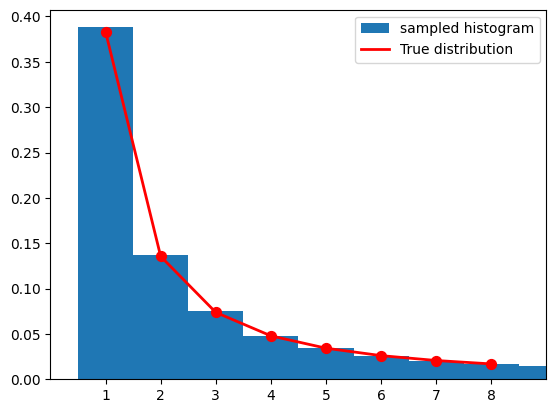

  Exact   distribution : [0.383 0.135 0.074 0.048 0.034 0.026 0.021 0.017 0.262]
Simulated distribution : [0.388 0.137 0.075 0.048 0.034 0.026 0.021 0.017 0.254]


In [65]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def Metropolis_Hastings(sample_num):
    state = 1
    X = np.zeros(sample_num)
    U1 = np.random.uniform(0, 1, sample_num) # generate new state
    U2 = np.random.uniform(0, 1, sample_num) # accept or reject
    for i in tqdm.tqdm(range(sample_num)):
        if state == 1:
            new_state = 2
            accept_rate = 2 ** (-5 / 2)
        else:
            if U1[i] <= 0.5:
                new_state = state - 1
                accept_rate = 1.0
            else:
                new_state = state + 1
                accept_rate = (state / (state + 1)) ** (3 / 2)

        if U2[i] <= accept_rate:
            state = new_state
        X[i] = state
    return X


sample_num = 1000000
burn_in = 10000
X = Metropolis_Hastings(sample_num)[burn_in:]
plt.hist(X, bins=np.arange(0.5, X.max() + 1, 1), density=True, label='sampled histogram')

# True PMF
def true_distribution(x):
    return x ** (-3/2)

x = np.arange(1, 9).astype(np.int64)
normalize_factor = np.sum(true_distribution(np.arange(1, 1000000).astype(np.int64)))
y = true_distribution(x) / normalize_factor
plt.plot(x, y, color='r', linewidth=2, linestyle='-', label='True distribution')
plt.scatter(x, y, color='r', s=50)
plt.xticks(x)
plt.legend()
plt.xlim(0, 9)
plt.show()

# i = 1, ..., 8, >= 9
y = np.concatenate([y, [1 - np.sum(y)]])
y_round = np.round(y, 3)
print(f'  Exact   distribution : {y_round}')

# get the X's PMF
simulated = np.histogram(X, bins=np.arange(0.5, X.max() + 1, 1), density=True)[0][:8]
simulated = np.concatenate([simulated, [1 - np.sum(simulated)]])
simulated_round = np.round(simulated, 3)
print(f'Simulated distribution : {simulated_round}')

# Problem 3

**Knapsack Problem:** $m=50, w=100$, each $g_j$ is sampled from the discrete uniform distribution over the supporting set $\{3,4,5,6,7\}$, each $w_j$ is chosen random from the discrete uniform distribution over the supporting set $\{2,4,6,8\}$.

Generate data:

In [1]:
import numpy as np
np.random.seed(0)

def generate_data(m, g_set, w_set):
    g = np.random.choice(g_set, m)
    w = np.random.choice(w_set, m)
    return g, w

m, W_limit = 50, 100
g_set = [3, 4, 5, 6, 7]
w_set = [2, 4, 6, 8]

g, w = generate_data(m, g_set, w_set)
print(f'{g = }')
print(f'{w = }')

g = array([7, 3, 6, 6, 6, 4, 6, 5, 7, 3, 3, 7, 5, 4, 3, 4, 4, 3, 4, 7, 6, 3,
       6, 3, 5, 6, 3, 4, 6, 6, 6, 3, 4, 4, 4, 3, 5, 7, 6, 6, 5, 7, 5, 3,
       3, 7, 3, 7, 4, 7])
w = array([4, 6, 6, 8, 2, 4, 4, 8, 4, 4, 8, 6, 8, 8, 6, 6, 8, 2, 6, 8, 4, 2,
       4, 6, 2, 8, 2, 6, 2, 8, 8, 2, 8, 2, 2, 2, 2, 6, 8, 2, 8, 6, 8, 8,
       4, 4, 4, 2, 4, 4])


(a) Find the maximization of the total worth of the treasure by using DP method

In [2]:
def DP(m, W_limit, g, w):
    dp = np.zeros((m + 1, W_limit + 1))
    for i in range(1, m + 1):
        for j in range(1, W_limit + 1):
            if j < w[i - 1]:
                dp[i][j] = dp[i - 1][j]
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i - 1][j - w[i - 1]] + g[i - 1])
    return dp[m][W_limit]

print(f'The maximization of the total worth of the treasure by using DP method is {DP(m, W_limit, g, w)}')

The maximization of the total worth of the treasure by using DP method is 150.0


(b) Find the maximization of the total worth of the treasure by using Metropolis-Hastings(MH) algorithm

In [ ]:
import numpy as np

def value_function1(g, w, state): # original
    return np.sum(state * g)

def value_function2(g, w, state): # cost_effectiveness
    total_weight = np.sum(state * w)
    if total_weight == 0:
        return 0
    return np.sum(state * g) / total_weight

def state_flip(s, flip_bit):
    new_s = s.copy()
    new_s[flip_bit] = 1 if s[flip_bit] == 0 else 0
    return new_s

def get_beta_values(beta, sample_num):
    if type(beta) == str:
        t = np.arange(0, sample_num)
        return 1 / np.log(sample_num // 2) * np.log(t + 1)
    return np.array([beta] * sample_num)


def Metropolis_Hastings(m, W_limit, g, w, beta, value_function, sample_num,):
    state = np.zeros(m)
    U = np.random.uniform(0, 1, sample_num)
    flip_bit = np.random.randint(0, m, sample_num)
    beta_values = get_beta_values(beta, sample_num)

    visited_states = {}
    for t in range(sample_num):
        worth = value_function(g, w, state)
        state_str = "".join(str(int(i)) for i in state)
        if state_str not in visited_states:
            visited_states[state_str] = [0, worth]
        else:
            visited_states[state_str][0] += 1

        new_state = state_flip(state, flip_bit[t])
        new_weight = np.sum(new_state * w)
        if new_weight > W_limit:
            continue

        new_worth = value_function(g, w, new_state)
        acceptance_rate = min(1, np.exp(beta_values[t] * (new_worth - worth)))
        if U[t] <= acceptance_rate:
            state = new_state

    best_state, _ = sorted(list(visited_states.items()), key=lambda x: x[1], reverse=True)[0]
    # convert the 01-string into a numpy array
    best_state = np.array([int(i) for i in best_state])
    return value_function1(g, w, best_state)


print(f'The maximization of the total worth of the treasure by using Metropolis-Hastings algorithm with different beta:')
sample_num = 50000
beta_list = [0.01, 0.1, 1, 10, 100, 'log(t+1)']

for value_function_type in range(1, 3):
    for beta in beta_list:
        value_function = value_function1 if value_function_type == 1 else value_function2
        worth = Metropolis_Hastings(m, W_limit, g, w, beta, value_function, sample_num)
        print(f'beta = {beta:<10}, V{value_function_type}, max total worth = {worth}')

The maximization of the total worth of the treasure by using Metropolis-Hastings algorithm with different beta:
beta = 0.01      , V1, max total worth = 98
beta = 0.1       , V1, max total worth = 81
beta = 1         , V1, max total worth = 142
beta = 10        , V1, max total worth = 103
beta = 100       , V1, max total worth = 102
beta = log(t+1)  , V1, max total worth = 144
beta = 0.01      , V2, max total worth = 99
beta = 0.1       , V2, max total worth = 110
beta = 1         , V2, max total worth = 108
beta = 10        , V2, max total worth = 7
beta = 100       , V2, max total worth = 7
beta = log(t+1)  , V2, max total worth = 91


# Problem 4

**Standard Normal Distribution:** generate samples from the standard normal distribution

(a) Implement a Metropolis-Hastings algorithm.

100%|██████████| 1000000/1000000 [00:01<00:00, 604171.48it/s]


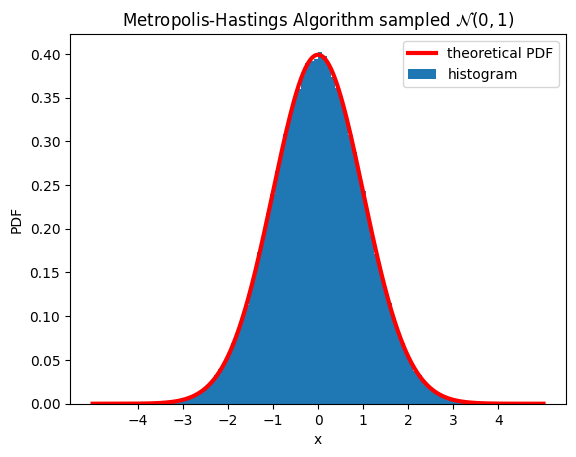

In [ ]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def Metropolis_Hastings(sample_num):
    state = 0
    new_states = np.random.exponential(1, sample_num) # generate new state
    U = np.random.uniform(0, 1, sample_num)           # accept or reject
    Y = np.zeros(sample_num)
    for i in tqdm.tqdm(range(sample_num)):
        new_state = new_states[i]
        accept_rate = min(np.exp(-new_state ** 2 / 2 + new_state + state ** 2 / 2 - state), 1)
        if U[i] <= accept_rate:
            state = new_state
        Y[i] = state

    U = np.random.uniform(0, 1, sample_num)
    X = np.where(U > 1 / 2, Y, -Y)
    return X


sample_num = 1000000
burn_in = 10000
X = Metropolis_Hastings(sample_num)[burn_in:]
plt.hist(X, bins=100, density=True)

# True PDF
def true_distribution(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x ** 2 / 2)

x = np.linspace(-5, 5, 1000)
pdf = true_distribution(x)
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Metropolis-Hastings Algorithm sampled $\mathcal{N}(0, 1)$')
plt.legend(['theoretical PDF', 'histogram'])
plt.xticks(np.arange(-4, 5))
plt.show()

(b) Implement a Hamiltonian Monte Carlo algorithm.

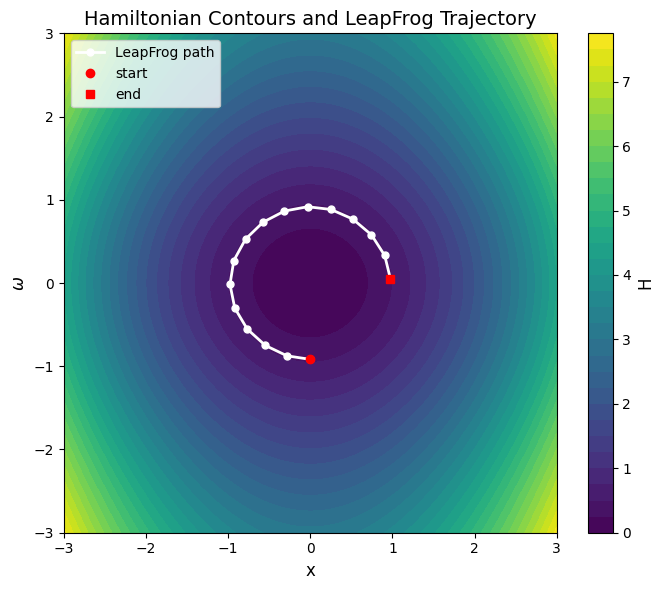

100%|██████████| 1000000/1000000 [00:15<00:00, 66373.58it/s]


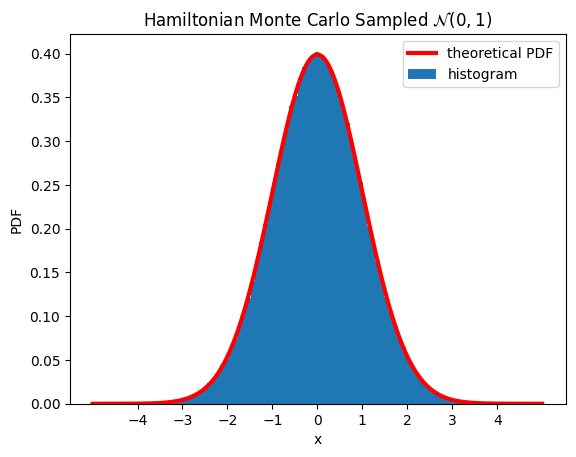

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# Set the Student-t distribution parameters (nu)
nu = 5

def LeapFrog(x, w, delta, L):
    for _ in range(L):
        w_half_step = w - 0.5 * delta * x
        x = x + delta * (nu + 1) / nu * w_half_step / (1 + w_half_step ** 2 / nu)
        w = w_half_step - 0.5 * delta * x

    return x, w


def show_sample_path(delta, L):
    x = 0
    w = np.random.standard_t(nu, 1)[0]  # sample from Student-t distribution
    num_points = 200
    x_vals = np.linspace(-3, 3, num_points)
    w_vals = np.linspace(-3, 3, num_points)
    X, W = np.meshgrid(x_vals, w_vals)
    H = 0.5 * X ** 2 + (nu + 1) / 2 * np.log(1 + W ** 2 / nu)

    # LeapFrog
    path = np.zeros((L + 1, 2))
    path[0] = (x, w)
    for i in range(1, L + 1):
        w_half_step = w - 0.5 * delta * x
        x = x + delta * (nu + 1) / nu * w_half_step / (1 + w_half_step ** 2 / nu)
        w = w_half_step - 0.5 * delta * x
        path[i] = (x, w)

    plt.figure(figsize=(7, 6))
    cont = plt.contourf(X, W, H, levels=30, cmap='viridis')

    # colorbar
    cbar = plt.colorbar(cont)
    cbar.set_label("H", fontsize=12)

    # trajectory
    plt.plot(path[:, 0], path[:, 1], color='white', marker='o', markersize=5, linewidth=2, label='LeapFrog path')
    plt.plot(path[0, 0], path[0, 1], 'ro', markersize=6, label='start')
    plt.plot(path[-1, 0], path[-1, 1], 'rs', markersize=6, label='end')

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("$\omega$", fontsize=12)
    plt.title("Hamiltonian Contours and LeapFrog Trajectory", fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def Hamiltonian_Monte_Carlo(sample_num, delta, L):
    samples = np.zeros((sample_num, 2))
    U = np.random.uniform(0, 1, sample_num)
    w_samples = np.random.standard_t(nu, sample_num) # sample from Student-t distribution
    x = 0
    for i in tqdm.tqdm(range(sample_num)):
        w = w_samples[i]
        x_new, w_new = LeapFrog(x, w, delta, L)
        w_new = -w_new  # flip the momentum's direction

        # Hamiltonian Energy
        current_U = 0.5 * x ** 2
        current_V = (nu + 1) / 2 * np.log(1 + w ** 2 / nu)
        proposed_U = 0.5 * x_new ** 2
        proposed_V = (nu + 1) / 2 * np.log(1 + w_new ** 2 / nu)

        acceptance_prob = min(np.exp((current_U + current_V) - (proposed_U + proposed_V)), 1)
        if U[i] < acceptance_prob:
            x = x_new
        samples[i] = (x, w)

    return samples


show_sample_path(delta=0.3, L=15)

sample_num = 1000000
burn_in = 10000
samples = Hamiltonian_Monte_Carlo(sample_num, delta=0.3, L=15)[burn_in:]

plt.hist(samples[:, 0], bins=100, density=True)

# Theoretical PDF of the standard Gaussian distribution
x = np.linspace(-5, 5, 1000)
pdf = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Hamiltonian Monte Carlo Sampled $\mathcal{N}(0,1)$')
plt.legend(['theoretical PDF','histogram'])
plt.xticks(np.arange(-4, 5))
plt.show()

(c) Implement with the Box-Muller Method.

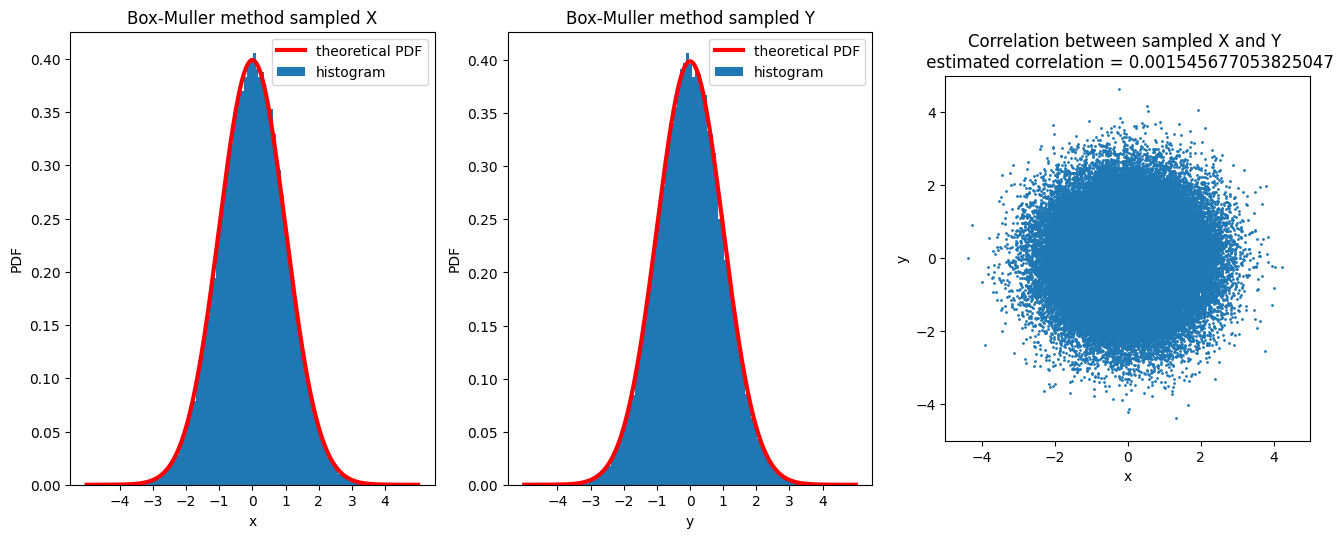

In [5]:
import numpy as np
import matplotlib.pyplot as plt

sample_nums = 100000
plt.figure(figsize=(16, 20))

# Theoretical PDF of the standard Gaussian distribution
x = np.linspace(-5, 5, 1000)
pdf = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

u1 = np.random.uniform(0, 1, sample_nums)
u2 = np.random.uniform(0, 1, sample_nums)
sampled_x = np.sqrt(-2 * np.log(u1)) * np.cos(2 * np.pi * u2)
sampled_y = np.sqrt(-2 * np.log(u1)) * np.sin(2 * np.pi * u2)

# show sampled_x and its theoretical PDF
plt.subplot(3, 3, 1)
plt.hist(sampled_x, bins=100, density=True)
# plt.plot(x, pdf) plot it wider and deeper color
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Box-Muller method sampled X')
plt.legend(['theoretical PDF','histogram'])
plt.xticks(np.arange(-4, 5))

# show the sampled_y and its theoretical PDF
plt.subplot(3, 3, 2)
plt.hist(sampled_y, bins=100, density=True)
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('y')
plt.ylabel('PDF')
plt.title('Box-Muller method sampled Y')
plt.legend(['theoretical PDF','histogram'])
plt.xticks(np.arange(-4, 5))

# show the correlation between sampled_x and sampled_y
# let the figure be a square
plt.subplot(3, 3, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(sampled_x, sampled_y, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.title(f'Correlation between sampled X and Y \n estimated correlation = {np.corrcoef(sampled_x, sampled_y)[0, 1]}')
plt.show()

# Problem 5

**Beta Normal Distribution:** generate samples from the beta distribution $\Beta(5,5)$

(a) Implement a Metropolis-Hastings algorithm.

100%|██████████| 1000000/1000000 [00:00<00:00, 1210451.84it/s]


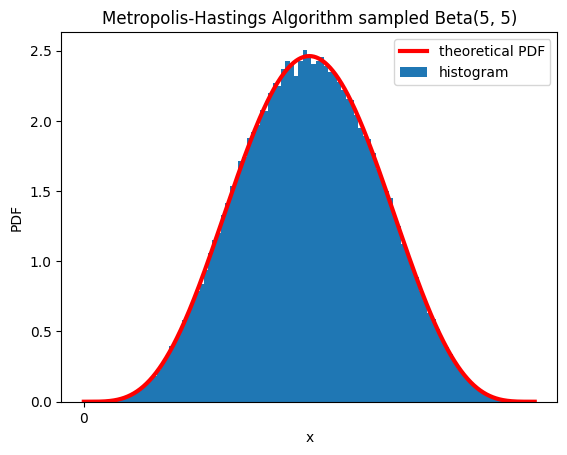

In [ ]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def Metropolis_Hastings(sample_num):
    state = 1e-5 # avoid device by zero
    new_states = np.random.uniform(0, 1, sample_num) # generate new state
    U = np.random.uniform(0, 1, sample_num)           # accept or reject
    X = np.zeros(sample_num)
    for i in tqdm.tqdm(range(sample_num)):
        new_state = new_states[i]
        accept_rate = min((new_state * (1 - new_state) / state / (1-state)) ** 4, 1)
        if U[i] <= accept_rate:
            state = new_state
        X[i] = state

    return X


sample_num = 1000000
burn_in = 10000
X = Metropolis_Hastings(sample_num)[burn_in:]
plt.hist(X, bins=100, density=True)

# True PDF
def true_distribution(x):
    return 630 * (x ** 4) * ((1 - x) ** 4)

x = np.linspace(0, 1, 1000)
pdf = true_distribution(x)
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Metropolis-Hastings Algorithm sampled Beta(5, 5)')
plt.legend(['theoretical PDF', 'histogram'])
plt.xticks(np.arange(0, 1))
plt.show()

(b) Implement a Hamiltonian Monte Carlo algorithm.

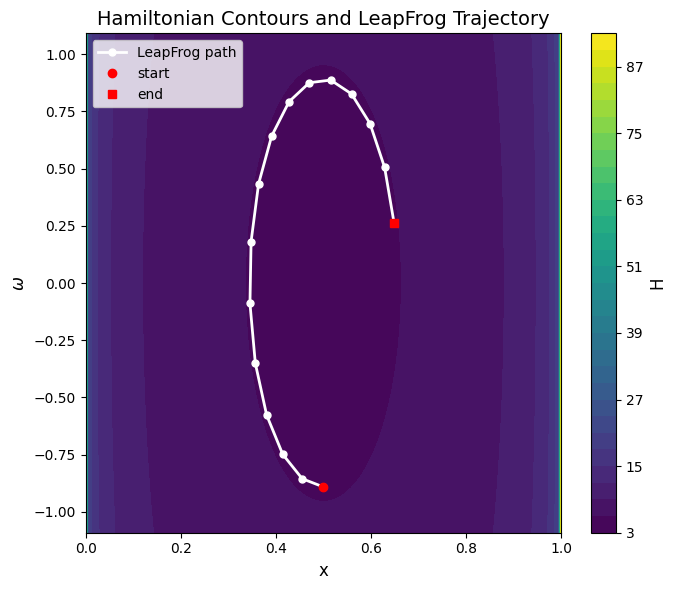

100%|██████████| 1000000/1000000 [00:21<00:00, 46890.37it/s]


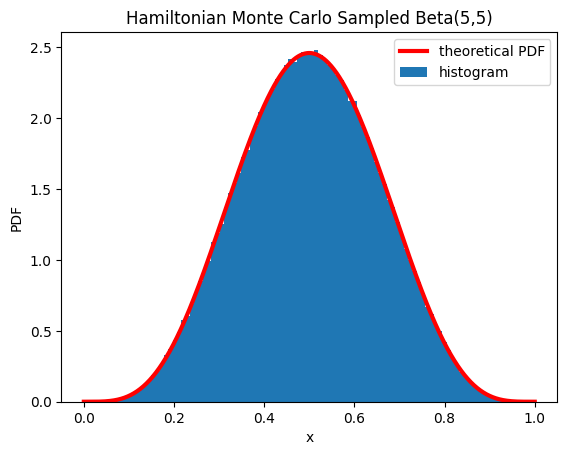

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm


def LeapFrog(x, w, delta, L):
    for _ in range(L):
        w_half_step = w - 0.5 * delta * (-4 / x + 4 / (1 - x))
        x = x + delta * w_half_step
        if x < 0:
            x = -x
            w = -w
        if x > 1:
            x = 2 - x
            w = -w
        w = w_half_step - 0.5 * delta * (-4 / x + 4 / (1 - x))

    return x, w


def show_sample_path(delta, L):
    x = 0.5
    w = np.random.normal(0, 1)
    maxn = abs(w) + 0.2
    num_points = 200
    x_vals = np.linspace(0, 1, num_points)
    w_vals = np.linspace(-maxn, maxn, num_points)
    X, W = np.meshgrid(x_vals, w_vals)
    X = X.clip(1e-10, 1 - 1e-10)
    H = -4 * np.log(X * (1 - X)) + 0.5 * W ** 2

    # LeapFrog
    path = np.zeros((L + 1, 2))
    path[0] = (x, w)
    for i in range(1, L + 1):
        w_half_step = w - 0.5 * delta * (-4 / x + 4 / (1 - x))
        x = x + delta * w_half_step
        x = np.clip(x, 1e-10, 1 - 1e-10)
        if x < 0:
            x = -x
            w = -w
        if x > 1:
            x = 2 - x
            w = -w
        w = w_half_step - 0.5 * delta * (-4 / x + 4 / (1 - x))
        path[i] = (x, w)

    plt.figure(figsize=(7, 6))
    cont = plt.contourf(X, W, H, levels=30, cmap='viridis')
    # plt.contour(X, W, H, levels=15, colors='white', alpha=0.3)

    # colorbar
    cbar = plt.colorbar(cont)
    cbar.set_label("H", fontsize=12)

    # trajectory
    plt.plot(path[:, 0], path[:, 1], color='white', marker='o', markersize=5, linewidth=2, label='LeapFrog path')
    plt.plot(path[0, 0], path[0, 1], 'ro', markersize=6, label='start')
    plt.plot(path[-1, 0], path[-1, 1], 'rs', markersize=6, label='end')

    plt.xlim(0, 1)
    plt.ylim(-maxn, maxn)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("$\omega$", fontsize=12)
    plt.title("Hamiltonian Contours and LeapFrog Trajectory", fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def Hamiltonian_Monte_Carlo(sample_num, delta, L):
    samples = np.zeros((sample_num, 2))
    U = np.random.uniform(0, 1, sample_num)
    w_samples = np.random.normal(0, 1, sample_num)
    x = 0.5
    for i in tqdm.tqdm(range(sample_num)):
        w = w_samples[i]
        x_new, w_new = LeapFrog(x, w, delta, L)
        x_new = np.clip(x_new, 1e-10, 1 - 1e-10)

        w_new = -w_new # flip the momentum's direction

        # Hamiltonian Energy
        current_U = -4 * np.log(x * (1 - x))
        current_V = 0.5 * w ** 2
        proposed_U = -4 * np.log(x_new * (1 - x_new))
        proposed_V = 0.5 * w_new ** 2

        acceptance_prob = min(np.exp((current_U + current_V) - (proposed_U + proposed_V)), 1)
        if U[i] < acceptance_prob:
            x = x_new
        samples[i] = (x, w)

    return samples

show_sample_path(delta=0.05, L=15)

sample_num = 1000000
burn_in = 10000
samples = Hamiltonian_Monte_Carlo(sample_num, delta=0.05, L=15)[burn_in:]

plt.hist(samples[:, 0], bins=100, density=True)

# Theoretical PDF of the standard Gaussian distribution
x = np.linspace(0, 1, 1000)
pdf = 630 * x ** 4 * (1 - x) ** 4
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Hamiltonian Monte Carlo Sampled Beta(5,5)')
plt.legend(['theoretical PDF','histogram'])
plt.show()

(c) Implement with the Acceptance-Rejection Method.

Accept rate = 0.0038838


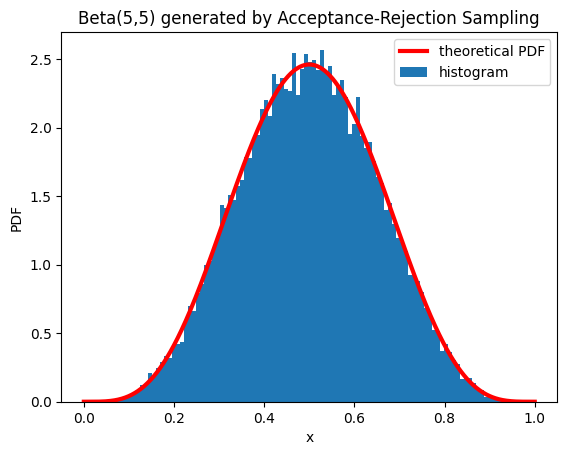

In [14]:
import numpy as np
import matplotlib.pyplot as plt

sample_nums = 10000000

Y = np.random.uniform(0, 1, sample_nums)
U = np.random.uniform(0, 1, sample_nums)

c = 315 / 128
FoverG = c * (Y ** 4) * ((1 - Y) ** 4)
X = Y[U < FoverG]
print(f'Accept rate = {len(X) / sample_nums}')

# histogram of X
plt.hist(X, bins=100, density=True)

# Beta(5,5) PDF
def beta(x):
    return 630 * (x ** 4) * ((1 - x) ** 4)
x = np.linspace(0, 1, 1000)
pdf = beta(x)
plt.plot(x, pdf, color='r', linewidth=3)


plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Beta(5,5) generated by Acceptance-Rejection Sampling')
plt.legend(['theoretical PDF','histogram'])
plt.xticks(np.arange(0, 1.01, 0.2))
plt.show()

# Problem 6

**Normal-Normal Conjugacy:** Implement a Metropolis-Hastings algorithm to find the posterior mean and variance of $\theta$ after observing the value of $Y=y$. The parameter setting: $y=3, \mu=0, \sigma^2=1, r^2=4$, and $d=0.1,0.5,1,5,10,100$.

100%|██████████| 10000/10000 [00:00<00:00, 434859.20it/s]


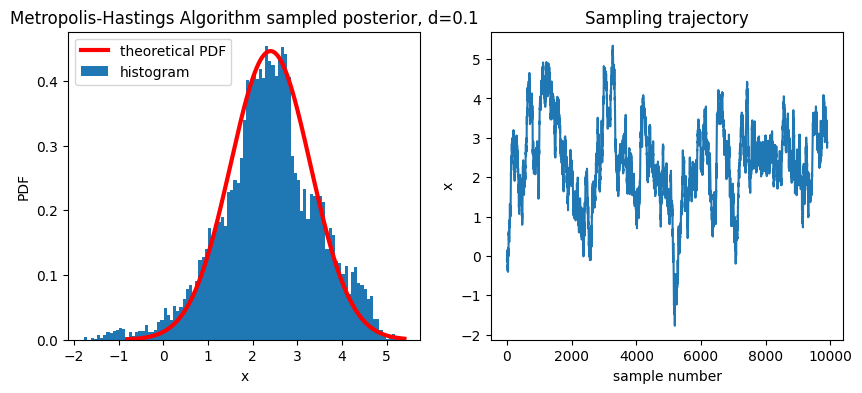

d=0.1: the estimation of the posterior mean is 2.376, variance is 1.149


100%|██████████| 10000/10000 [00:00<00:00, 259981.28it/s]


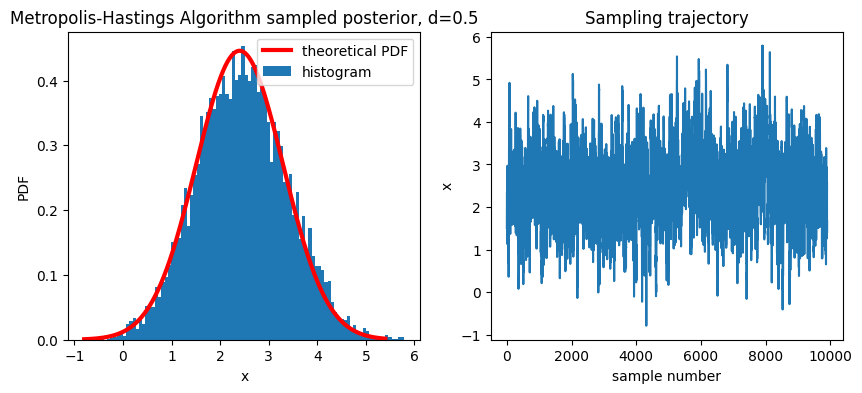

d=0.5: the estimation of the posterior mean is 2.454, variance is 0.869


100%|██████████| 10000/10000 [00:00<00:00, 333341.60it/s]


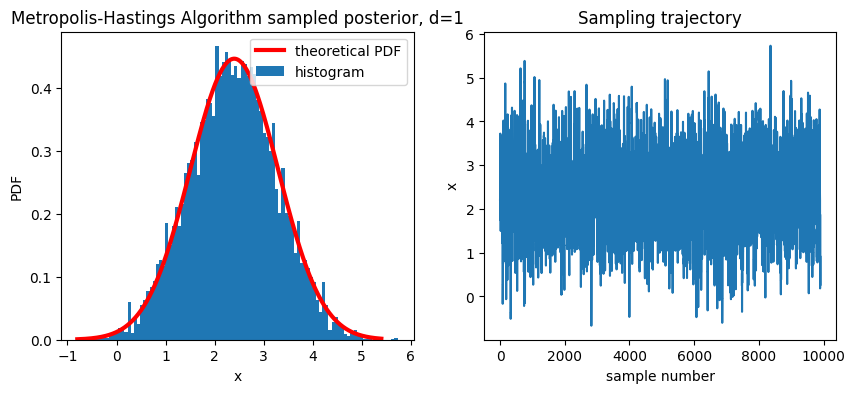

d=1: the estimation of the posterior mean is 2.377, variance is 0.806


100%|██████████| 10000/10000 [00:00<00:00, 434687.95it/s]


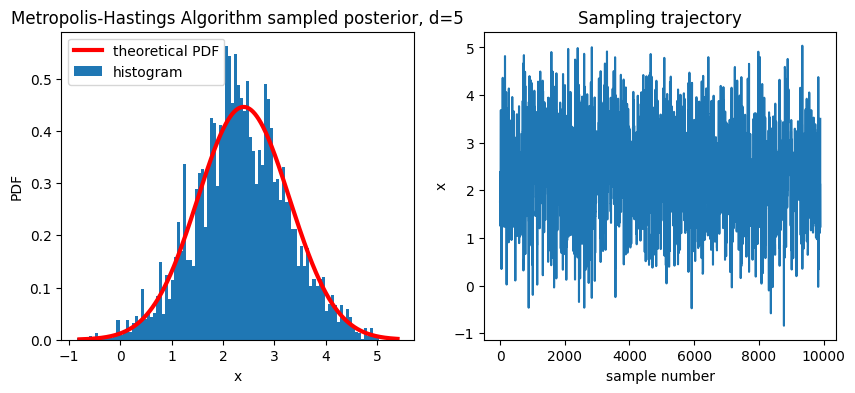

d=5: the estimation of the posterior mean is 2.355, variance is 0.797


100%|██████████| 10000/10000 [00:00<00:00, 407851.50it/s]


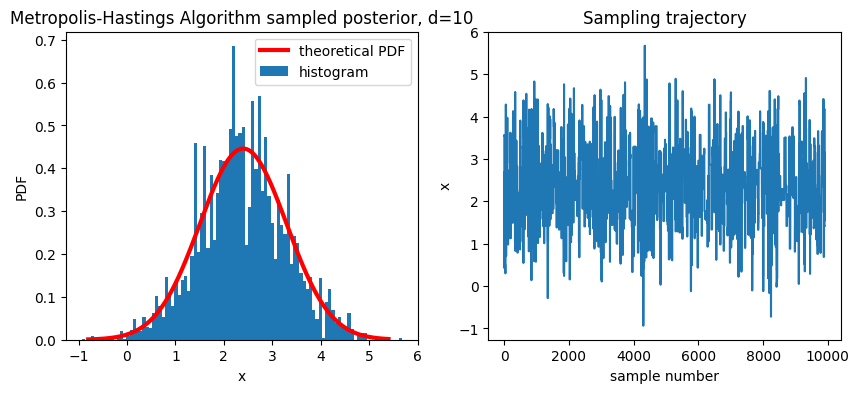

d=10: the estimation of the posterior mean is 2.382, variance is 0.794


100%|██████████| 10000/10000 [00:00<00:00, 357214.37it/s]


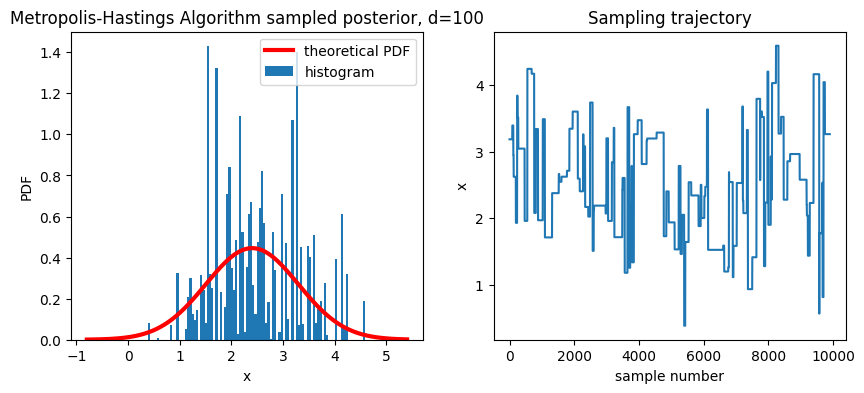

d=100: the estimation of the posterior mean is 2.521, variance is 0.701


In [20]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def normal_value(x, mu, sigma_square):
    return 1 / np.sqrt(2 * np.pi * sigma_square) * np.exp(-(x - mu) ** 2 / (2 * sigma_square))

# True PDF
def posterior_distribution(x, y, mu, sigma_square, tau_square):
    true_mu = 1 / (1 / sigma_square + 1 / tau_square) * (y / sigma_square + mu / tau_square)
    true_sigma_square = 1 / (1 / sigma_square + 1 / tau_square)
    return normal_value(x, true_mu, true_sigma_square)


def Metropolis_Hastings(sample_num, y, mu, sigma_square, tau_square, d):
    samples = np.zeros(sample_num)
    new_states = np.random.normal(0, 1, sample_num)   # generate new state
    U = np.random.uniform(0, 1, sample_num)           # accept or reject
    x = 0
    for i in tqdm.tqdm(range(sample_num)):
        x_new = x + d * new_states[i]
        accept_rate = min(np.exp(-1 / 2 / sigma_square * (y - x_new) ** 2 - 1 / 2 / tau_square * (x_new - mu) ** 2 + 1 / 2 / sigma_square * (y - x) ** 2 + 1 / 2 / tau_square * (x - mu) ** 2), 1)
        if U[i] <= accept_rate:
            x = x_new
        samples[i] = x

    return samples


y = 3
mu = 0
sigma_square = 1
tau_square = 4
d_list = [0.1, 0.5, 1, 5, 10, 100]

sample_num = 10000
burn_in = 100

for d in d_list:
    x = np.linspace(-0.8, 5.4, 1000)
    pdf = posterior_distribution(x, y, mu, sigma_square, tau_square)

    # set the figure size to be wider
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, pdf, color='r', linewidth=3)

    samples = Metropolis_Hastings(sample_num, y, mu, sigma_square, tau_square, d)[burn_in:]
    plt.hist(samples, bins=100, density=True)
    plt.xlabel('x')
    plt.ylabel('PDF')
    plt.title(f'Metropolis-Hastings Algorithm sampled posterior, d={d}')
    plt.legend(['theoretical PDF', 'histogram'])

    # show the trajectory of x
    plt.subplot(1, 2, 2)
    plt.plot(samples)
    plt.xlabel('sample number')
    plt.ylabel('x')
    plt.title(f'Sampling trajectory')
    plt.show()

    print(f'd={d}: the estimation of the posterior mean is {np.mean(samples):.3f}, variance is {np.var(samples):.3f}')

# Problem 7
**Bivariate Standard Normal Distribution:** Implement a Gibbs sampler to generate samples from a bivariate standard normal distribution with correlation $\rho=0.6,-0.6$.

100%|██████████| 1000000/1000000 [00:02<00:00, 469321.27it/s]


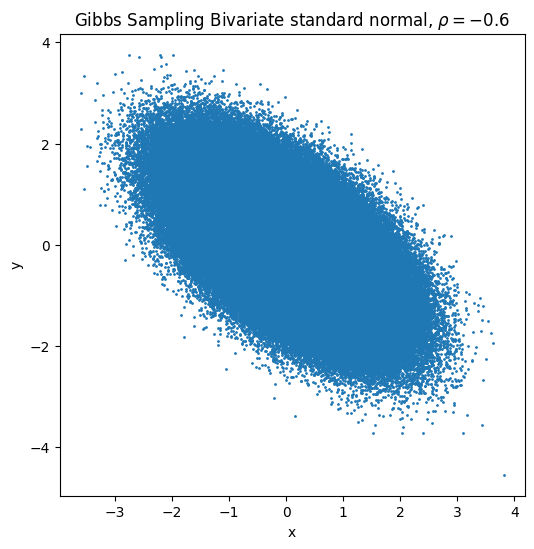

100%|██████████| 1000000/1000000 [00:02<00:00, 475903.97it/s]


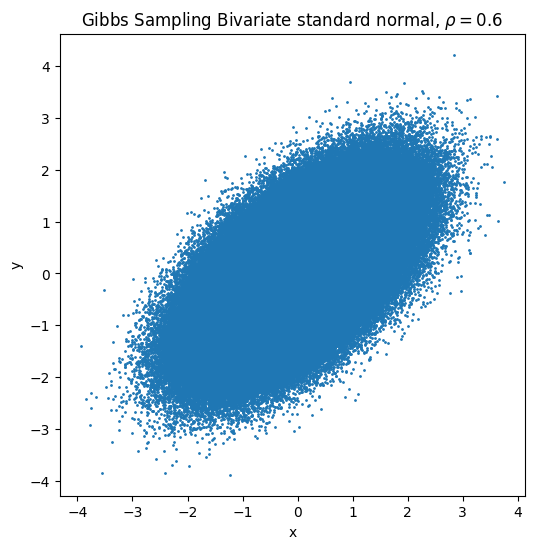

In [ ]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt


def Gibbs(rho, sample_num):
    state = (0, 0)
    samples = np.zeros((sample_num, 2))
    for i in tqdm.tqdm(range(sample_num)):
        x = np.random.normal(rho * state[1], 1 - rho ** 2)
        y = np.random.normal(rho * x, 1 - rho ** 2)
        state = (x, y)
        samples[i] = state

    return samples


sample_num = 1000000
burn_in = 10000
rhos = [-0.6, 0.6]
for rho in rhos:
    samples = Gibbs(rho, sample_num)[burn_in:]
    # show the 2D samples
    X = samples[:, 0]
    Y = samples[:, 1]
    plt.figure(figsize=(6, 6))
    plt.scatter(X, Y, s=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Gibbs Sampling Bivariate standard normal, $\\rho = {rho}$')
    plt.show()

# Problem 8

**Chicken-Egg with Unknown Parameters:** The parameter setting: $\lambda=10, a=b=1, x=7$.

(a) Implement a Gibbs sampler to find the posterior mean and the variance of $p$ after observing $x$ hatched eggs.

100%|██████████| 1000000/1000000 [00:02<00:00, 461372.02it/s]


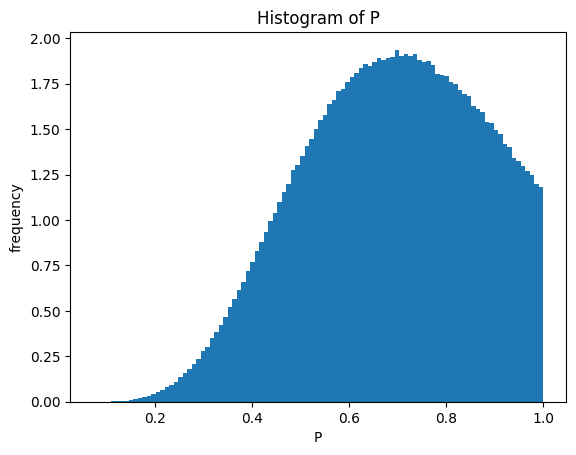

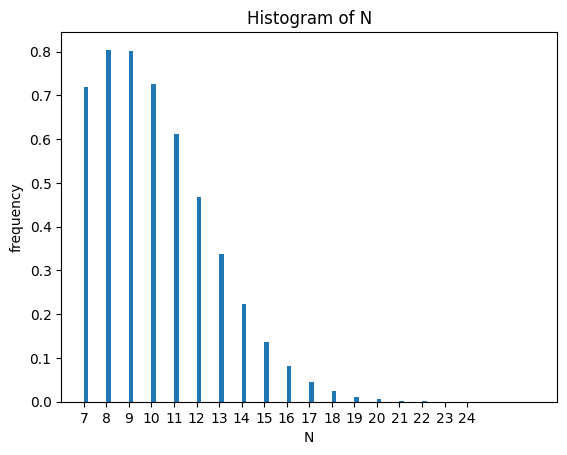

The estimated P given X = 7 has mean: 0.68449, variance: 0.03196


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def Gibbs(lamb, a, b, x, sample_num):
    samples = np.zeros((sample_num, 2)) # p, n
    state = (0.5, 7)
    for i in tqdm.tqdm(range(sample_num)):
        p, n = state
        p_new = np.random.beta(a + x, b + n - x)
        n_new = x + np.random.poisson(lamb * (1 - p_new))
        state = (p_new, n_new)
        samples[i] = state
    return samples


sample_num = 1000000
burn_in = 1000
lamb = 10
a, b = 1, 1
x = 7
samples = Gibbs(lamb, a, b, x, sample_num)[burn_in:]

P = samples[:, 0]
N = samples[:, 1]
plt.hist(P, bins=100, density=True)
plt.xlabel('P')
plt.ylabel('frequency')
plt.title('Histogram of P')
plt.show()

plt.hist(N, bins=100, density=True)
plt.xlabel('N')
plt.ylabel('frequency')
plt.title('Histogram of N')
plt.xticks(np.arange(7, 25, 1))
plt.show()

print(f'The estimated P given X = {x} has mean: {np.mean(P):.5f}, variance: {np.var(P):.5f}')

(b) Implement a Metropolis-Hastings algorithm to find the posterior mean and variance of $p$ after observing $x$ hatched eggs.

100%|██████████| 1000000/1000000 [00:02<00:00, 361326.62it/s]


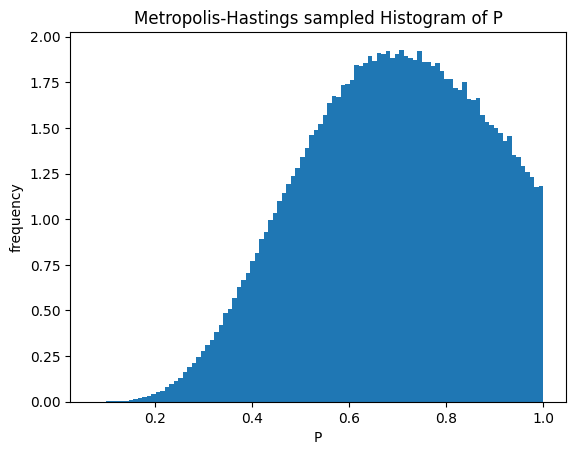

The estimated P given X = 7 has mean: 0.68468, variance: 0.03198


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def Metropolis_Hastings(lamb, a, b, x, sample_num):
    state = 0.5
    new_states = np.random.uniform(0, 1, sample_num)    # generate new state
    U = np.random.uniform(0, 1, sample_num)             # accept or reject
    samples = np.zeros(sample_num)
    for i in tqdm.tqdm(range(sample_num)):
        new_state = new_states[i]
        new_value = np.exp(-lamb * new_state) * (lamb * new_state) ** x * new_state ** (a - 1) * (1 - new_state) ** (b-1)
        old_value = np.exp(-lamb * state) * (lamb * state) ** x * state ** (a - 1) * (1 - state) ** (b-1)
        accept_rate = min(new_value / old_value, 1)
        if U[i] <= accept_rate:
            state = new_state
        samples[i] = state

    return samples


sample_num = 1000000
burn_in = 1000
lamb = 10
a, b = 1, 1
x = 7

samples = Metropolis_Hastings(lamb, a, b, x, sample_num)[burn_in:]
plt.hist(samples, bins=100, density=True)
plt.xlabel('P')
plt.ylabel('frequency')
plt.title('Metropolis-Hastings sampled Histogram of P')
plt.show()

print(f'The estimated P given X = {x} has mean: {np.mean(samples):.5f}, variance: {np.var(samples):.5f}')

# Problem 9
**Three-dimensional Joint Distribution:** Implement a Gibbs sampler to generate samples from the three-dimensional joint distribution shown in the lecture.


100%|██████████| 1000000/1000000 [00:03<00:00, 316794.23it/s]


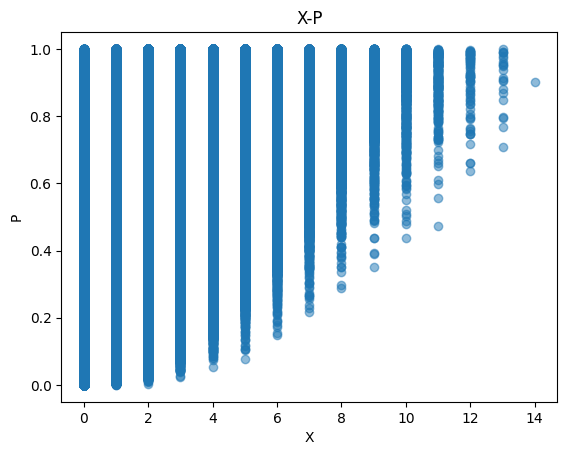

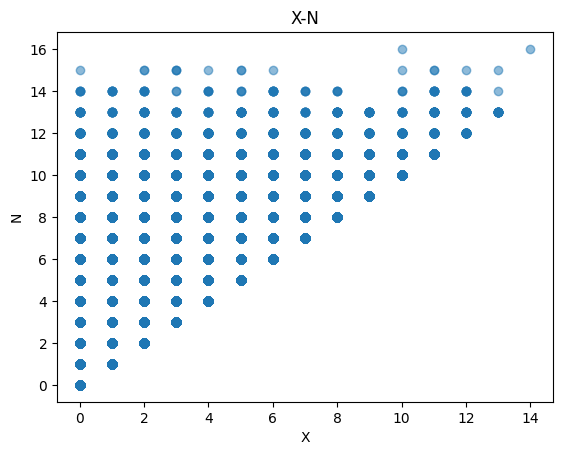

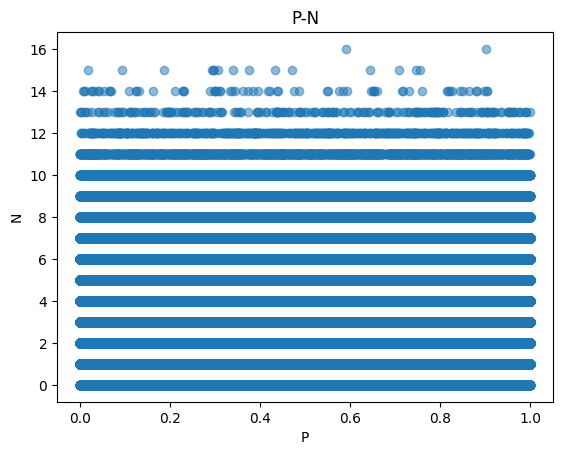

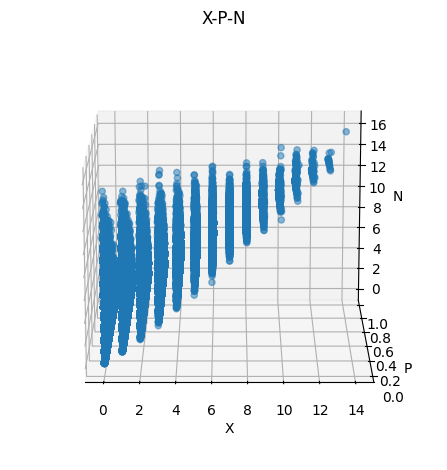

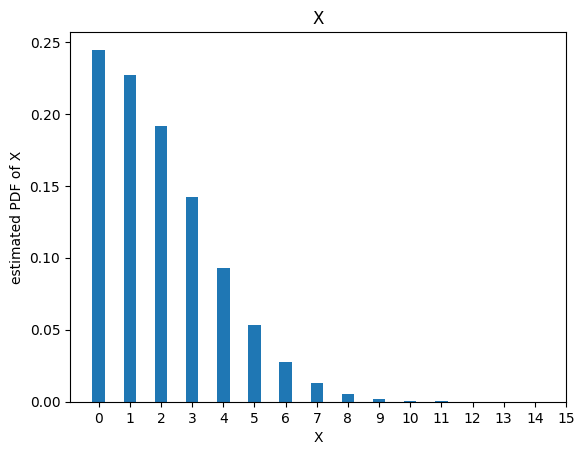

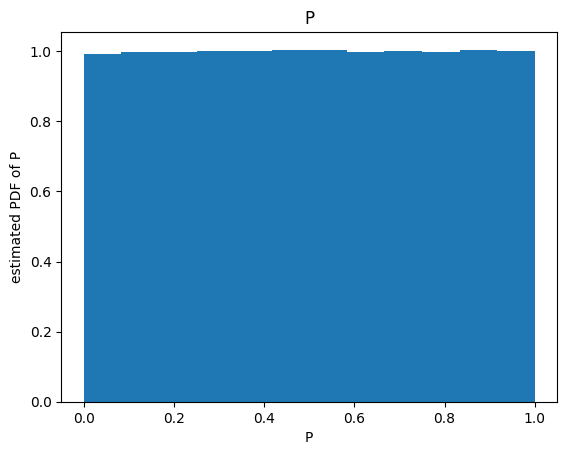

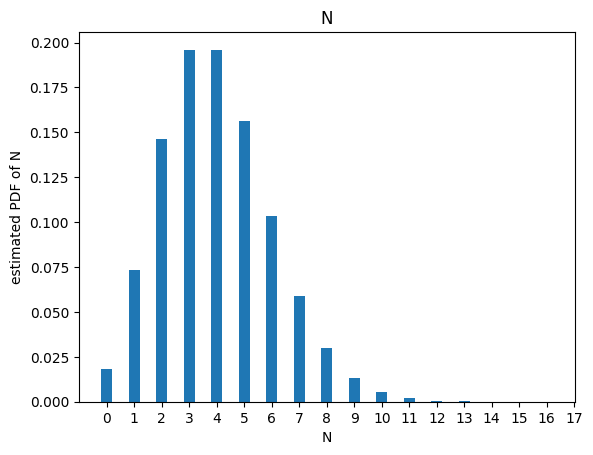

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

def Gibbs(sample_num):
    state = (1, 0.5, 2) # (x, p, n)
    samples = np.zeros((sample_num, 3))
    for i in tqdm.tqdm(range(sample_num)):
        x, p, n = state
        x_new = np.random.binomial(n, p)
        p_new = np.random.beta(x_new + 1, n - x_new + 1)
        n_new = x_new + np.random.poisson(4 * (1 - p_new))

        state = (x_new, p_new, n_new)
        samples[i] = state

    return samples

def plot_samples(samples):
    X = samples[:, 0]
    P = samples[:, 1]
    N = samples[:, 2]

    plt.scatter(X, P, alpha=0.5)
    plt.title("X-P")
    plt.xlabel("X")
    plt.ylabel("P")
    plt.show()

    plt.scatter(X, N, alpha=0.5)
    plt.title("X-N")
    plt.xlabel("X")
    plt.ylabel("N")
    plt.show()

    plt.scatter(P, N, alpha=0.5)
    plt.title("P-N")
    plt.xlabel("P")
    plt.ylabel("N")
    plt.show()

    ax = plt.figure().add_subplot(111, projection='3d')
    ax.scatter(X, P, N, alpha=0.5, s=20)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    ax.set_zlabel('N')
    ax.view_init(elev=15, azim=-90)
    plt.title("X-P-N")
    plt.tight_layout()
    plt.show()

    plt.hist(X, bins=np.arange(min(X) - 0.5, max(X) + 1.5, 1), density=True, rwidth=0.4, align='mid')
    plt.xticks(np.arange(0, max(X) + 2, 1))
    plt.title("X")
    plt.xlabel("X")
    plt.ylabel("estimated PDF of X")
    plt.show()

    plt.hist(P, bins=12, density=True)
    plt.title("P")
    plt.xlabel("P")
    plt.ylabel("estimated PDF of P")
    plt.show()

    plt.hist(N, bins=np.arange(min(N) - 0.5, max(N) + 1.5, 1), density=True, rwidth=0.4, align='mid')
    plt.xticks(np.arange(0, max(N) + 2, 1))
    plt.title("N")
    plt.xlabel("N")
    plt.ylabel("estimated PDF of N")
    plt.show()


sample_num = 1000000
burn_in = 10000
samples = Gibbs(sample_num)[burn_in:]
plot_samples(samples)

# Problem 10

**Example I in the Lecture, Section 4**

(a) Implement a Metropolis-Hastings algorithm.

100%|██████████| 1000000/1000000 [00:01<00:00, 947409.06it/s]


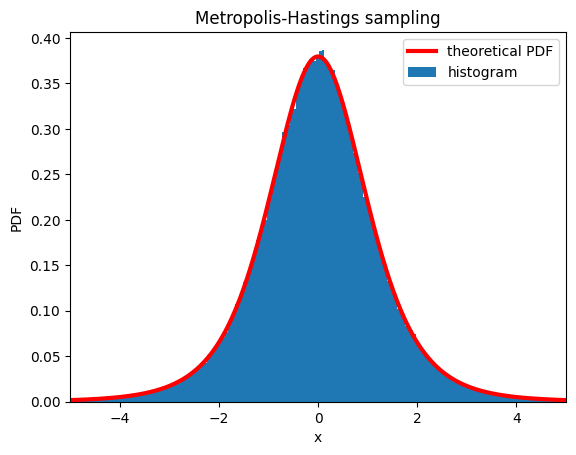

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm


def Demormation_Cauchy(sample_num):
    U = np.random.uniform(0, 1, sample_num)
    X = np.sqrt(5) * np.tan(np.pi * (U - 0.5))
    return X


def Metropolis_Hastings(sample_num):
    state = 0
    new_states = Demormation_Cauchy(sample_num)    # generate new state
    U = np.random.uniform(0, 1, sample_num)         # accept or reject
    samples = np.zeros(sample_num)
    for i in tqdm.tqdm(range(sample_num)):
        new_state = new_states[i]
        accept_rate = min(((1 + state ** 2 / 5) / (1 + new_state ** 2 / 5)) ** 2, 1)
        if U[i] <= accept_rate:
            state = new_state
        samples[i] = state
    return samples


sample_num = 1000000
burn_in = 1000
samples = Metropolis_Hastings(sample_num)[burn_in:]
plt.hist(samples, bins=1000, density=True)

def get_pdf(x):
    return 8 / (3 * np.pi * np.sqrt(5)) * ((1 + (x ** 2) / 5) ** (-3))
x = np.linspace(-5, 5, 1000)
pdf = get_pdf(x)
plt.plot(x, pdf, color='r', linewidth=3)

plt.xlabel('x')
plt.ylabel('PDF')
plt.xlim(-5, 5)
plt.title('Metropolis-Hastings sampling')
plt.legend(['theoretical PDF','histogram'])
plt.show()

(b) Implement a Hamiltotinn Monte Carlo algorithm

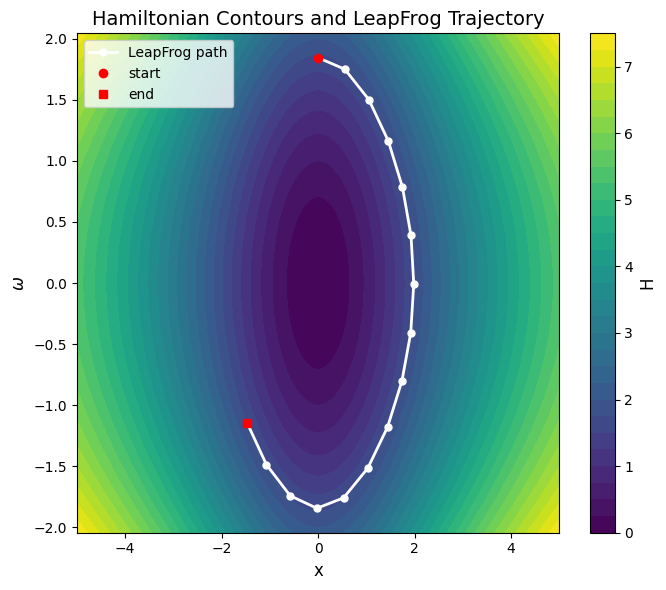

100%|██████████| 1000000/1000000 [00:16<00:00, 60752.27it/s]


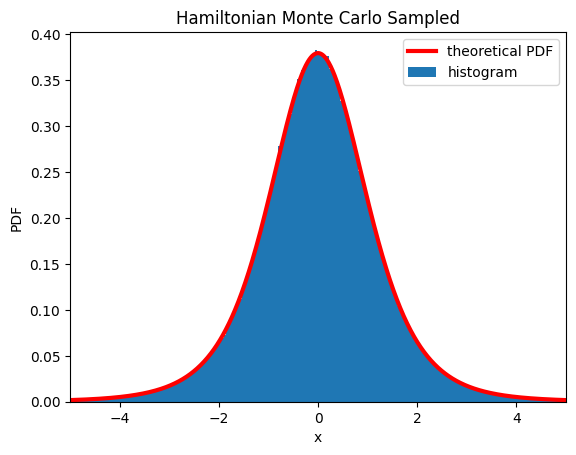

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm


def LeapFrog(x, w, delta, L):
    for _ in range(L):
        w_half_step = w - 0.5 * delta * (6 * x / (5 + x ** 2))
        x = x + delta * w_half_step
        w = w_half_step - 0.5 * delta * (6 * x / (5 + x ** 2))

    return x, w


def show_sample_path(delta, L):
    x = 0
    w = np.random.normal(0, 1)
    maxn = abs(w) + 0.2
    num_points = 200
    x_vals = np.linspace(-5, 5, num_points)
    w_vals = np.linspace(-maxn, maxn, num_points)
    X, W = np.meshgrid(x_vals, w_vals)
    H = 3 * np.log(1 + X ** 2 / 5) + 0.5 * W ** 2

    # LeapFrog
    path = np.zeros((L + 1, 2))
    path[0] = (x, w)
    for i in range(1, L + 1):
        w_half_step = w - 0.5 * delta * (6 * x / (5 + x ** 2))
        x = x + delta * w_half_step
        w = w_half_step - 0.5 * delta * (6 * x / (5 + x ** 2))
        path[i] = (x, w)

    plt.figure(figsize=(7, 6))
    cont = plt.contourf(X, W, H, levels=30, cmap='viridis')
    # plt.contour(X, W, H, levels=15, colors='white', alpha=0.3)

    # colorbar
    cbar = plt.colorbar(cont)
    cbar.set_label("H", fontsize=12)

    # trajectory
    plt.plot(path[:, 0], path[:, 1], color='white', marker='o', markersize=5, linewidth=2, label='LeapFrog path')
    plt.plot(path[0, 0], path[0, 1], 'ro', markersize=6, label='start')
    plt.plot(path[-1, 0], path[-1, 1], 'rs', markersize=6, label='end')

    plt.xlim(-5, 5)
    plt.ylim(-maxn, maxn)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("$\omega$", fontsize=12)
    plt.title("Hamiltonian Contours and LeapFrog Trajectory", fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def Hamiltonian_Monte_Carlo(sample_num, delta, L):
    samples = np.zeros((sample_num, 2))
    U = np.random.uniform(0, 1, sample_num)
    w_samples = np.random.normal(0, 1, sample_num)
    x = 0
    for i in tqdm.tqdm(range(sample_num)):
        w = w_samples[i]
        x_new, w_new = LeapFrog(x, w, delta, L)
        w_new = -w_new # flip the momentum's direction

        # Hamiltonian Energy
        current_U = 3 * np.log(1 + x ** 2 / 5)
        current_V = 0.5 * w ** 2
        proposed_U = 3 * np.log(1 + x_new ** 2 / 5)
        proposed_V = 0.5 * w_new ** 2

        acceptance_prob = min(np.exp((current_U + current_V) - (proposed_U + proposed_V)), 1)
        if U[i] < acceptance_prob:
            x = x_new
        samples[i] = (x, w)

    return samples

show_sample_path(delta=0.3, L=15)

sample_num = 1000000
burn_in = 10000
samples = Hamiltonian_Monte_Carlo(sample_num, delta=0.3, L=15)[burn_in:]

plt.hist(samples[:, 0], bins=1000, density=True)

# Theoretical PDF of the standard Gaussian distribution
x = np.linspace(-5, 5, 1000)
pdf = 8 / (3 * np.pi * np.sqrt(5)) * ((1 + (x ** 2) / 5) ** (-3))
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Hamiltonian Monte Carlo Sampled')
plt.legend(['theoretical PDF','histogram'])
plt.xlim(-5, 5)
plt.show()

(c) Implement with the Aoceptance-Rejection Method.

Accept rate = 0.375255


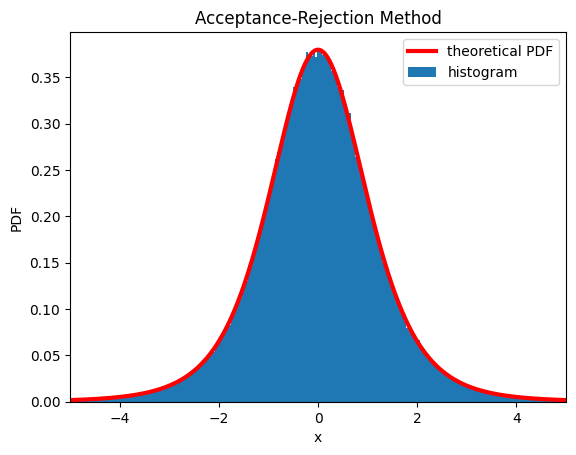

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sample_nums = 1000000

U1 = np.random.uniform(0, 1, sample_nums)
Y = np.sqrt(5) * np.tan(np.pi * (U1 - 0.5))
U2 = np.random.uniform(0, 1, sample_nums)

FoverG = (1 + (Y ** 2) / 5) ** (-2)
X = Y[U2 < FoverG]
print(f'Accept rate = {len(X) / sample_nums}')

# histogram of X
plt.hist(X, bins=1000, density=True)

def get_pdf(x):
    return 8 / (3 * np.pi * np.sqrt(5)) * ((1 + (x ** 2) / 5) ** (-3))
x = np.linspace(-5, 5, 1000)
pdf = get_pdf(x)
plt.plot(x, pdf, color='r', linewidth=3)


plt.xlabel('x')
plt.ylabel('PDF')
plt.xlim(-5, 5)
plt.title('Acceptance-Rejection Method')
plt.legend(['theoretical PDF','histogram'])
plt.show()

# Problem 11

**Example II in the Lecture, Section 4**

(a) Implement a Metropolis-Hastings algorithm.

100%|██████████| 1000000/1000000 [00:03<00:00, 278535.46it/s]


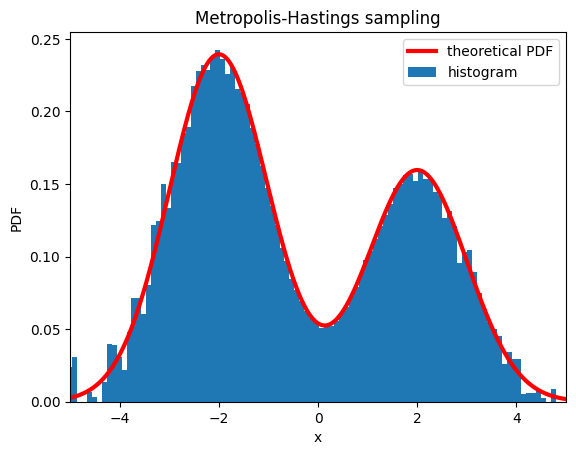

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

def Metropolis_Hastings(sample_num):
    state = 0
    new_states = np.random.normal(0, 1, sample_num)    # generate new state
    U = np.random.uniform(0, 1, sample_num)            # accept or reject
    samples = np.zeros(sample_num)
    for i in tqdm.tqdm(range(sample_num)):
        new_state = new_states[i]
        accept_rate = min((2 * np.exp(2 * new_state - 2) + 3 * np.exp(-2 * new_state - 2)) / (2 * np.exp(2 * state - 2) + 3 * np.exp(-2 * state - 2)), 1)
        if U[i] <= accept_rate:
            state = new_state
        samples[i] = state
    return samples


sample_num = 1000000
burn_in = 10000
samples = Metropolis_Hastings(sample_num)[burn_in:]
plt.hist(samples, bins=100, density=True)

def get_pdf(x):
    return 0.4 / np.sqrt(2 * np.pi) * np.exp(-(x - 2) ** 2 / 2) + 0.6 / np.sqrt(2 * np.pi) * np.exp(-(x + 2) ** 2 / 2)
x = np.linspace(-5, 5, 1000)
pdf = get_pdf(x)
plt.plot(x, pdf, color='r', linewidth=3)

plt.xlabel('x')
plt.ylabel('PDF')
plt.xlim(-5, 5)
plt.title('Metropolis-Hastings sampling')
plt.legend(['theoretical PDF','histogram'])
plt.show()

(b) Implement a Hamiltonian Monte Carlo algorithm

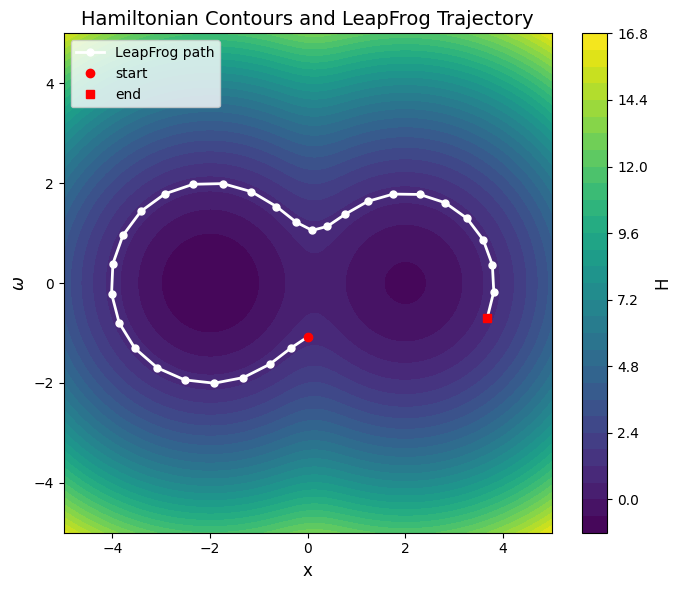

100%|██████████| 100000/100000 [00:21<00:00, 4560.67it/s]


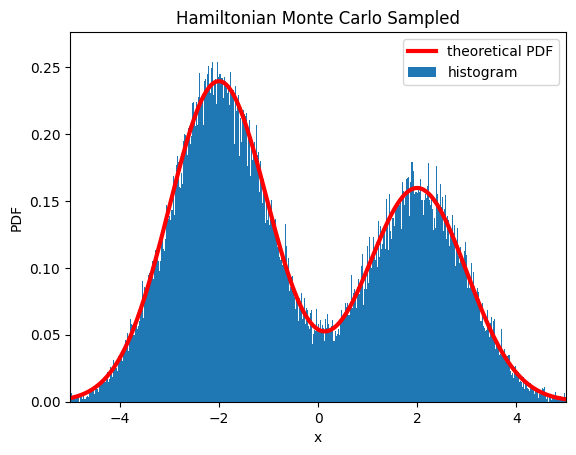

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm


def LeapFrog(x, w, delta, L):
    for _ in range(L):
        w_half_step = w - 0.5 * delta * (2 * (x - 2) * np.exp(-0.5 * (x - 2) ** 2) + 3 * (x + 2) * np.exp(-0.5 * (x + 2) ** 2)) / (2 * np.exp(-0.5 * (x - 2) ** 2) + 3 * np.exp(-0.5 * (x + 2) ** 2))
        x = x + delta * w_half_step
        w = w_half_step - 0.5 * delta * (2 * (x - 2) * np.exp(-0.5 * (x - 2) ** 2) + 3 * (x + 2) * np.exp(-0.5 * (x + 2) ** 2)) / (2 * np.exp(-0.5 * (x - 2) ** 2) + 3 * np.exp(-0.5 * (x + 2) ** 2))

    return x, w


def show_sample_path(delta, L):
    x = 0
    w = np.random.normal(0, 1)
    num_points = 200
    x_vals = np.linspace(-5, 5, num_points)
    w_vals = np.linspace(-5, 5, num_points)
    X, W = np.meshgrid(x_vals, w_vals)
    H = -np.log(2 * np.exp(-0.5 * (X - 2) ** 2) + 3 * np.exp(-0.5 * (X + 2) ** 2)) + 0.5 * W ** 2

    # LeapFrog
    path = np.zeros((L + 1, 2))
    path[0] = (x, w)
    for i in range(1, L + 1):
        w_half_step = w - 0.5 * delta * (2 * (x - 2) * np.exp(-0.5 * (x - 2) ** 2) + 3 * (x + 2) * np.exp(-0.5 * (x + 2) ** 2)) / (2 * np.exp(-0.5 * (x - 2) ** 2) + 3 * np.exp(-0.5 * (x + 2) ** 2))
        x = x + delta * w_half_step
        w = w_half_step - 0.5 * delta * (2 * (x - 2) * np.exp(-0.5 * (x - 2) ** 2) + 3 * (x + 2) * np.exp(-0.5 * (x + 2) ** 2)) / (2 * np.exp(-0.5 * (x - 2) ** 2) + 3 * np.exp(-0.5 * (x + 2) ** 2))
        path[i] = (x, w)

    plt.figure(figsize=(7, 6))
    cont = plt.contourf(X, W, H, levels=30, cmap='viridis')
    # plt.contour(X, W, H, levels=15, colors='white', alpha=0.3)

    # colorbar
    cbar = plt.colorbar(cont)
    cbar.set_label("H", fontsize=12)

    # trajectory
    plt.plot(path[:, 0], path[:, 1], color='white', marker='o', markersize=5, linewidth=2, label='LeapFrog path')
    plt.plot(path[0, 0], path[0, 1], 'ro', markersize=6, label='start')
    plt.plot(path[-1, 0], path[-1, 1], 'rs', markersize=6, label='end')

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("$\omega$", fontsize=12)
    plt.title("Hamiltonian Contours and LeapFrog Trajectory", fontsize=14)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


def Hamiltonian_Monte_Carlo(sample_num, delta, L):
    samples = np.zeros((sample_num, 2))
    U = np.random.uniform(0, 1, sample_num)
    w_samples = np.random.normal(0, 1, sample_num)
    x = 0
    for i in tqdm.tqdm(range(sample_num)):
        w = w_samples[i]
        x_new, w_new = LeapFrog(x, w, delta, L)
        w_new = -w_new # flip the momentum's direction

        # Hamiltonian Energy
        current_U = -np.log(2 * np.exp(-0.5 * (x - 2) ** 2) + 3 * np.exp(-0.5 * (x + 2) ** 2))
        current_V = 0.5 * w ** 2
        proposed_U = -np.log(2 * np.exp(-0.5 * (x_new - 2) ** 2) + 3 * np.exp(-0.5 * (x_new + 2) ** 2))
        proposed_V = 0.5 * w_new ** 2

        acceptance_prob = min(np.exp((current_U + current_V) - (proposed_U + proposed_V)), 1)
        if U[i] < acceptance_prob:
            x = x_new
        samples[i] = (x, w)

    return samples

show_sample_path(delta=0.3, L=30)

sample_num = 100000
burn_in = 10000
samples = Hamiltonian_Monte_Carlo(sample_num, delta=0.3, L=30)[burn_in:]

plt.hist(samples[:, 0], bins=1000, density=True)

# Theoretical PDF of the standard Gaussian distribution
x = np.linspace(-5, 5, 1000)
pdf = 0.4 / np.sqrt(2 * np.pi) * np.exp(-(x - 2) ** 2 / 2) + 0.6 / np.sqrt(2 * np.pi) * np.exp(-(x + 2) ** 2 / 2)
plt.plot(x, pdf, color='r', linewidth=3)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Hamiltonian Monte Carlo Sampled')
plt.legend(['theoretical PDF','histogram'])
plt.xlim(-5, 5)
plt.show()

(c) Implement with the Acceptance-Rejection Method.

Accept rate = 0.760735


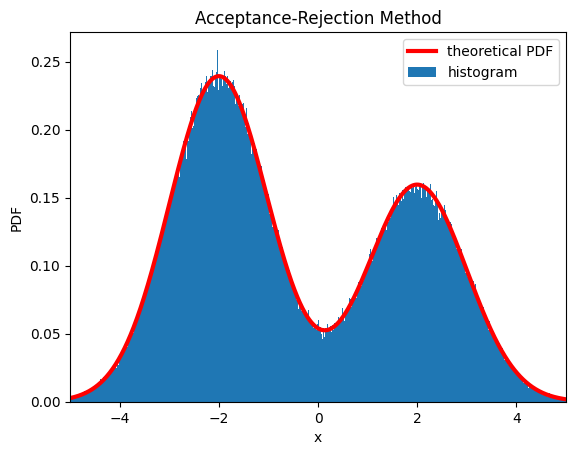

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Exponential Distribution
def exponential_inverse(x): # the inverse of the exponential distribution
    return -np.log(1 - x)

def inverse_transform_sampling(sample_nums): # inverse transform sampling
    u = np.random.uniform(0, 1, sample_nums) # uniform random numbers
    return exponential_inverse(u)

def acceptance_rejection_normal(sample_nums):
    # Y ~ Expo(1)
    Y = inverse_transform_sampling(sample_nums) # sample points using inverse transform sampling
    FoverG = np.exp(- 1 / 2 * ((Y - 1) ** 2))
    U1 = np.random.uniform(0, 1, sample_nums)
    Z = Y[U1 < FoverG]

    U2 = np.random.uniform(0, 1, len(Z))
    X = np.where(U2 > 1 / 2, Z, -Z)
    return X


sample_nums = 1000000
X1 = acceptance_rejection_normal(sample_nums) + 2
X2 = acceptance_rejection_normal(sample_nums) - 2
sampled = min(len(X1), len(X2))
print(f'Accept rate = {sampled / sample_nums}')

X1 = X1[:sampled]
X2 = X2[:sampled]
U = np.random.uniform(0, 1, sampled)

X = np.where(U < 0.4, X1, X2)

# histogram of X
plt.hist(X, bins=1000, density=True)

# Beta(5,5) PDF
def get_pdf(x):
    return 0.4 / np.sqrt(2 * np.pi) * np.exp(-(x - 2) ** 2 / 2) + 0.6 / np.sqrt(2 * np.pi) * np.exp(-(x + 2) ** 2 / 2)
x = np.linspace(-5, 5, 1000)
pdf = get_pdf(x)
plt.plot(x, pdf, color='r', linewidth=3)


plt.xlabel('x')
plt.ylabel('PDF')
plt.xlim(-5, 5)
plt.title('Acceptance-Rejection Method')
plt.legend(['theoretical PDF','histogram'])
plt.show()

# Problem 14

**Markov Chain Monte Carlo for Wireless Networks.** Given a wireless network with 24 links and $0-1$ interference model, i.e., any two links are either intefere with each other or not. To describe the interference relationship between wireless links, we introduce the conflict graph model. In such model, the vertex of the conflict graph represents the wircless link. An edge between two vertioes means corresponding two links interfere with each other. The following Figure shows the corresponding conflict graph for 24-link wireless network. You are required to find the maximum independent set of the conflict graph, i.e., the largest set of wireless links that can simultancously transmit without interferences. Design the algorithm by MCMC method and evaluate your algorithm.

<center>
  <img width = "400" src="./tex/figure/p14/graph.png" alt="graph">
</center>

In [1]:
import numpy as np
import tqdm


def check_valid(vertex):
    # i + 1 is the real number in to graph
    # 0  <= i <= 11: connection (i, i + 12), (i, (i + 4) % 12), (i, (i + 8) % 12)
    # 12 <= i <= 23: connection (i, i + 1)
    for i in range(len(vertex)):
        if 0 <= i <= 11:
            if (vertex[i] & vertex[i + 12]) or (vertex[i] & vertex[(i + 4) % 12]) or (vertex[i] & vertex[(i + 8) % 12]):
                return False
        elif 12 <= i <= 22:
            if (vertex[i] & vertex[i + 1]):
                return False
        elif i == 23:
            if (vertex[23] & vertex[12]):
                return False
    return True


def state_flip(s, flip_bit):
    new_s = s.copy()
    new_s[flip_bit] = 1 if s[flip_bit] == 0 else 0
    return new_s


def get_neibors(state):
    neighbors = []
    for flip_bit in range(24):
        new_state = state_flip(state, flip_bit)
        if check_valid(new_state):
            neighbors.append(new_state)
    return np.array(neighbors)


def get_beta_values(sample_num):
    t = np.arange(0, sample_num)
    return 1 / np.log(sample_num // 2) * np.log(t + 1)

(a) Show your MCMC Design with a discrete Markow chain. Use both theory and simulation results to justify your algorithms.

In [4]:
def Discrete_MCMC(sample_num):
    state = np.zeros(24, dtype=np.int8)
    flip_bit = np.random.randint(0, 24, sample_num)
    U = np.random.uniform(0, 1, sample_num)
    beta = get_beta_values(sample_num)
    visited_states = set()

    for t in tqdm.tqdm(range(sample_num)):
        new_state = state_flip(state, flip_bit[t])
        if not check_valid(new_state):
            continue

        acceptance_rate = min(np.exp(beta[t] * (np.sum(new_state) - np.sum(state))), 1)
        if U[t] <= acceptance_rate:
            state = new_state

        state_str = "".join(str(int(i)) for i in state)
        if state_str not in visited_states:
            visited_states.add(state_str)

    max_num = 0
    for key in visited_states:
        # key is a string, count its number of ones
        num = key.count('1')
        if num > max_num:
            max_num = num

    print(f"The number of elements in the maximum independent set is: {max_num}, the maximum independent set is:")
    for key in visited_states:
        if max_num == key.count('1'):
            print(key)

sample_num = 10000
Discrete_MCMC(sample_num)

100%|██████████| 10000/10000 [00:00<00:00, 71126.79it/s]

The number of elements in the maximum independent set is: 9, the maximum independent set is:
010010100001101001010100
010010000011100101010100
101001000001010010101010
001011010000010100100101
000010110100010101001001
010100101000101001010010
101000010100010100101010
010000101001101001010010
101001000001010100101010
000010010110010100101001
001010000101100101010010
000100101100101001010010
010000101001100101010010
010000101001101001010100
001101001000010010010101
010010100001101001001010
010100101000101010010010
101000000101010101001010
100000010110010100101001
000010100101101001001010
101101000000010010010101
000010100101100101001010
101000010100010010101010
001010010100010100101001
100000110100010101001010
011010000001100101010010
001011010000010100101001
001010010100100100101010
010000001011101001010100
101000010100010101001010
101001010000010100100101
101000000101010101010010
010010000011101001010100
100000110100010101001001
101000010100010101001001
010010110000100101001010
1010000

(b) Show your MCMC Design with a continnous Markov chain. Use both theory and simulation results to justify your algorithms.

In [4]:
def Continuous_MCMC(sample_num):
    state = np.zeros(24, dtype=np.int8)
    U = np.random.uniform(0, 1, sample_num)
    beta = get_beta_values(sample_num)
    visited_states = set()

    for t in tqdm.tqdm(range(sample_num)):
        neibors = get_neibors(state)
        new_state = neibors[np.random.choice(len(neibors))]
        acceptance_rate = min(np.exp(beta[t] * (np.sum(new_state) - np.sum(state))), 1)
        if U[t] <= acceptance_rate:
            state = new_state

        state_str = "".join(str(int(i)) for i in state)
        if state_str not in visited_states:
            visited_states.add(state_str)

    max_num = 0
    for key in visited_states:
        # key is a string, count its number of ones
        num = key.count('1')
        if num > max_num:
            max_num = num

    print(f"The number of elements in the maximum independent set is: {max_num}, the maximum independent set is:")
    for key in visited_states:
        if max_num == key.count('1'):
            print(key)

sample_num = 10000
Continuous_MCMC(sample_num)

100%|██████████| 10000/10000 [00:02<00:00, 4416.69it/s]

The number of elements in the maximum independent set is: 9, the maximum independent set is:
110000010010001010101001
010100101000001001010101
101100000100010010101001
001101001000010010010101
000010100101100101010010
101001010000010010101010
101000010100010100101001
001010000101100101010010
000011010010010100101001
101101000000010010101001
100001010010010100100101
010110100000001001010101
000010110100010101001010
100001010010010010100101
001011000001100100101010
100000010110010100101001
000010010110010100101001
101001000001010010101010
100000100101010101010010
101000010100010101001010
001010010100010101001001
101101000000010010101010
100101000010010010010101
101000000101010101001010
010100001010101010100100
010010100001100101001010
000000101101010101010010
100000010110010101001001
001010000101010101010010
001001011000010100100101
000010100101101001010010
010000101001101010010010
100100000110010010101001
001101001000010010100101
100101000010010010100101
100000010110001010101001
0110100